In [1]:
import joblib
from sim_utils.modeling import create_model, create_reg_model, update_config
from utils.quack import Quack
from sim_utils.config import CONFIG
print("import successful")


pbp = Quack.query("""
select 
	out_of_bounds,
	play_id,
	pbp.game_id,
	posteam,
	side_of_field,
	"desc",
	case when timeout =1 and posteam = timeout_team then 'pos_timeout'
		when timeout =1 and defteam = timeout_team then 'def_timeout'
		else play_type end as play_type,
	quarter_seconds_remaining,
	half_seconds_remaining,
	game_seconds_remaining,
	yards_gained as yards,
	air_yards,
	yards_after_catch as yac,
	complete_pass,
	timeout,
	sp,
	yardline_100,
	down,
	goal_to_go,
	ydstogo,
	posteam_score,
	defteam_score,
	score_differential,
	wind,
	temp,
	spread_line,
	total_line,
	posteam_timeouts_remaining,
	defteam_timeouts_remaining,
	qtr as quarter
from pbp
join team_feats as t
on pbp.posteam = t.team
and t.game_id = pbp.game_id
join opp_feats as o
on pbp.defteam = o.opponent_team
and o.game_id = pbp.game_id
                  """)

import successful


In [4]:
decoder = CONFIG['play_encoding']
decoder

{'def_timeout': 8,
 'field_goal': 0,
 'kickoff': 9,
 'no_play': 1,
 'pass': 2,
 'pos_timeout': 7,
 'punt': 3,
 'qb_kneel': 4,
 'qb_spike': 5,
 'run': 6}

In [5]:
decoder = CONFIG['play_encoding']
pbp['play_type_enc'] = pbp['play_type'].apply(lambda x: decoder.get(x,0)).astype(int)

In [6]:
pbp.loc[(pbp.quarter==4) & (pbp.game_seconds_remaining < 200)].groupby('play_type')['out_of_bounds'].mean()

play_type
def_timeout    0.044776
extra_point    0.000000
field_goal     0.000478
kickoff        0.062577
no_play        0.040797
pass           0.116586
pos_timeout    0.028037
punt           0.076399
qb_kneel       0.000000
qb_spike       0.000000
run            0.043818
Name: out_of_bounds, dtype: float64

In [7]:
pbp.game_id

0           2002_09_MIA_GB
1           2002_09_MIA_GB
2           2002_09_MIA_GB
3           2002_09_MIA_GB
4           2002_09_MIA_GB
                ...       
1068153    2002_09_DAL_DET
1068154    2002_09_DAL_DET
1068155    2002_09_DAL_DET
1068156    2002_09_DAL_DET
1068157    2002_09_DAL_DET
Name: game_id, Length: 1068158, dtype: object

In [8]:
pbp['out_of_bounds'].mean()

np.float64(0.07759713450631836)

In [9]:
from sim_utils.config import CONFIG
oob_x = [
    "play_type_enc",
    "quarter_seconds_remaining",
    "half_seconds_remaining",
    "game_seconds_remaining",
    "yards",
    "air_yards",
    "yac",
    "complete_pass",
    "yardline_100",
    "down",
    "goal_to_go",
    "ydstogo",
    "score_differential",
    "temp",
    "spread_line",
    "total_line",
    "posteam_timeouts_remaining",
    "quarter",
]
oob_y = "out_of_bounds"
pbp = pbp.loc[(pbp.play_type.isin(['kickoff', 'run', 'pass','punt'])) & ((pbp.complete_pass ==1 ) | (pbp.play_type != 'pass'))]
oob_model = create_model(pbp, oob_x, oob_y)

print("oob model created..")
joblib.dump(oob_model, "models/oob_model.joblib")

feature_config = {
    "oob_cols": oob_x,
}
update_config(feature_config)

Accuracy: 0.89
Confusion Matrix:
[[129815    109]
 [ 15212    122]]
oob model created..


In [10]:
pbp['play_type'].unique()

array(['kickoff', 'run', 'punt', 'pass'], dtype=object)

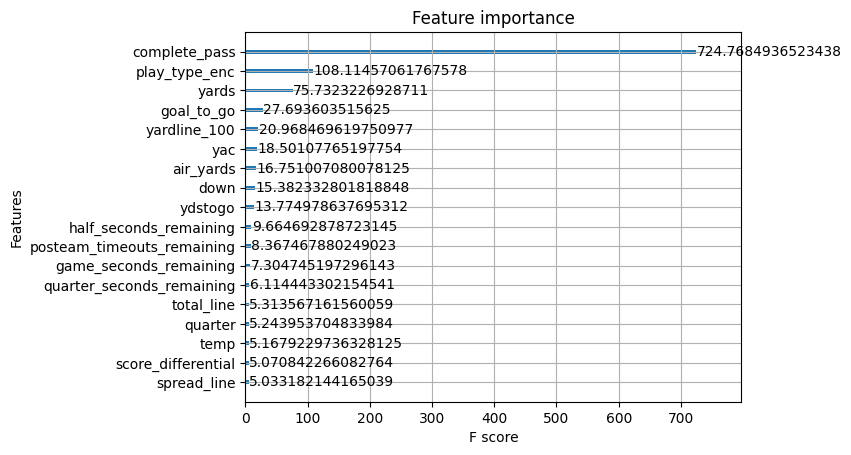

In [11]:
import xgboost as xgb
import matplotlib.pyplot as plt

# If oob_model is XGBClassifier / XGBRegressor
xgb.plot_importance(oob_model, importance_type='gain', max_num_features=20)
plt.show()


In [12]:
oob_model.predict_proba(pbp[oob_x].iloc[0:10])

array([[0.8996433 , 0.10035671],
       [0.98502034, 0.01497964],
       [0.90169007, 0.09830996],
       [0.97194916, 0.02805085],
       [0.8991428 , 0.10085719],
       [0.73595047, 0.2640495 ],
       [0.8446343 , 0.15536569],
       [0.97826177, 0.02173823],
       [0.95910877, 0.04089122],
       [0.9147034 , 0.08529659]], dtype=float32)

In [ ]:
.33